## PnL Explain :  Estimating PnL using sensitivities and Market Data
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/01-use-cases/finance/front-office/pnl-explained/main.ipynb)._]

For more context and definitions around pnl explained, [check out our article on atoti.io](https://www.atoti.io/pnl-explained-with-atoti/).

### A few definitions:

- [Portfolio](https://www.investopedia.com/terms/p/portfolio.asp) refers to any collection of financial assets such as stocks, bonds and cash. 
- [PnL](https://www.investopedia.com/terms/p/plstatement.asp) is a common term used in trading referring to the total "Profit and Loss" made by a portfolio over a certain time period.
- [Maturity date](https://www.investopedia.com/terms/m/maturitydate.asp) refers to the due date on which a borrower must pay back the principal of a debt, i.e. the initial amount of money borrowed.
- [Tenor](https://www.investopedia.com/terms/t/tenor.asp) refers to the length of time remaining in a contract, while maturity refers to the initial length of the agreement upon its inception. The tenor of a financial instrument declines over time, whereas its maturity remains constant.
- [Yield curve](https://www.investopedia.com/terms/y/yieldcurve.asp) is a graphical representation of interest rates per maturity date.
- [Sensitivity](https://www.investopedia.com/terms/s/sensitivity.asp) is the magnitude of a financial instrument's reaction to changes in underlying factors.
- [Greeks](https://www.investopedia.com/terms/g/greeks.asp) describes the different dimensions of risk involved in taking an options position. 
- [Delta](https://www.investopedia.com/terms/d/delta.asp), in particular, is a first-order greek, and represents the ratio that compares the change in the price of an asset to the corresponding change in the price of its derivative. For example, if a stock option has a delta value of 0.75, this means that if the underlying stock increases in price by 1 dollar per share, the option on it will rise by 0.75 dollars per share.

### Introduction

The PnL explain technique seeks to estimate the daily PnL from the change in the underlying risk factors.
In this case the risk factors are determined by the yield curve plotting interest rates for each tenor.

Usually, a portfolio risk manager will monitor the risk factors that impact his portfolio, instead of monitoring all the positions booked in his portfolio. To assess what will be the value of his portfolio, a portfolio risk manager is interested in performing what-if analysis based on a scenario of the risk factor values.

In this notebook, we perform a simplified PnL Explained by using Delta(Δ) to represent our sensitivity instead of the full Greeks. We will utilize the various features of atoti libraries to:

- Load data into a multi-dimensional cube
- Explore the Data using the embedded visualization or atoti UI
- Calculate Estimated PnL using sensitivities and Market Data
- Run multiple scenarios of the Yield Curve Stress Test

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=pnl-explained" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

In [1]:
import atoti as tt

In [2]:
# Create an atoti session
session = tt.Session(user_content_storage="content")

## 1.1 Loading Data and creating ActivePivot multidimensional environment
### Creating atoti DataStore

There are many ways atoti can consume data. In this notebook, we will be using read_csv to load data into the datastores.

### Position Sensitivities

In [3]:
position_sensitivity = session.read_csv(
    "s3://data.atoti.io/notebooks/pnl-explained/position_sensitivities.csv",
    keys=["book_id", "instrument_code", "currency", "curve", "tenor"],
    table_name="Position_Sensitivities",
)

In [4]:
# you can use head(n) to view the first n rows of the store.
# likewise, you can use position_sensitivity.columns to view the columns available in the store
# lastly, you can use {"columns": len(position_sensitivity.columns), "rows": len(position_sensitivity)} to view the number of rows and columns loaded into the table
position_sensitivity.head(5)

notional  sensi
book_id instrument_code currency curve       tenor                   
1       NL00000001      EUR      EUR-Govt-NL 1Y     10000000.0   0.01
3       CH00002001      CHF      CHF-Govt-CH 7Y     10000000.0   0.01
                                             9Y     10000000.0   0.01
4       IT00003007      EUR      EUR-Govt-IT 9Y     10000000.0   0.01
7       FR00006001      EUR      EUR-Govt-FR 5Y     10000000.0   0.01

### Position Data

In [5]:
position_table = session.read_csv(
    "s3://data.atoti.io/notebooks/pnl-explained/position_data.csv",
    keys=["book_id", "instrument_code"],
    table_name="Position",
)

In [6]:
position_table.head(5)

,,maturity_date,coupon_rate,nominal,currency,curve,issuer_country
book_id,instrument_code,,,,,,
1,NL00000001,1,0.03,10000000.0,EUR,EUR-Govt-NL,Netherlands
17,CH00016001,1,0.01,10000000.0,CHF,CHF-Govt-CH,Switzerland
21,UK00020009,9,0.03,10000000.0,GBP,GBP-Govt-UK,United Kingdom
24,DK00023007,7,0.02,10000000.0,DKK,EUR-Govt-DK,Denmark
2,DE00081007,7,0.02,10000000.0,EUR,EUR-Govt-DE,Germany


### Portfolio structure

In [7]:
trading_desk_table = session.read_csv(
    "s3://data.atoti.io/notebooks/pnl-explained/trading_desk.csv",
    keys=["book_id"],
    table_name="Trading_Desk",
)

In [8]:
trading_desk_table.head(5)

,book,trading_desk,sub_business_unit,business_unit,folio_id,portfolio,fund,sub_asset_class,asset_class
book_id,,,,,,,,,
19,CH03,Chronos,Foreign Rates & Credit,Rates & Credit,19,CH03,Chronos,Foreign Rates & Credit,Rates & Credit
39,HE03,Hera,Frontier Market,Forex,39,HE03,Hera,Frontier Market,Forex
20,CH04,Chronos,Foreign Rates & Credit,Rates & Credit,20,CH04,Chronos,Foreign Rates & Credit,Rates & Credit
40,HE04,Hera,Frontier Market,Forex,40,HE04,Hera,Frontier Market,Forex
1,HE01,Hermes,Domestic Rates & Credit,Rates & Credit,1,HE01,Hermes,Domestic Rates & Credit,Rates & Credit


### Market data

In [9]:
market_data_table = session.read_csv(
    "s3://data.atoti.io/notebooks/pnl-explained/market_data.csv",
    keys=["currency", "curve", "tenor"],
    table_name="Market_Data",
)

In [10]:
market_data_table.head()

start_of_day    last
currency curve       tenor                      
EUR      EUR-Govt-FR 1Y            0.010  0.0101
         EUR-Govt-DE 3Y            0.016  0.0161
                     5Y            0.018  0.0181
CHF      CHF-Govt-CH 6Y            0.019  0.0191
GBP      GBP-Govt-UK 3Y            0.016  0.0161

### Creating references between stores  

We will proceed to set up references between the stores that we just created. We will perform the join from `position_sensitivity`.

In [11]:
position_sensitivity.join(
    trading_desk_table,
    (position_sensitivity["book_id"] == trading_desk_table["book_id"]),
)

In [12]:
position_sensitivity.join(
    position_table,
    (position_sensitivity["book_id"] == position_table["book_id"])
    & (position_sensitivity["instrument_code"] == position_table["instrument_code"]),
)

In [13]:
position_sensitivity.join(
    market_data_table,
    (position_sensitivity["currency"] == market_data_table["currency"])
    & (position_sensitivity["curve"] == market_data_table["curve"])
    & (position_sensitivity["tenor"] == market_data_table["tenor"]),
)

### Creating cube  
We create the cube using the base store *position_sensitivity*.   
Note that we have not passed in any mode in create_cube().  
This means that a hierarchy will be automatically created for each non-numeric column and measure will be automatically created for each numeric column.  

In [14]:
cube = session.create_cube(position_sensitivity, "Position_Sensitivities")

We can see that all the stores are joined to *Position Sensitivities Store*, this is what we call the base store.  
For a record to be reachable in the cube, it must exists in the base store.

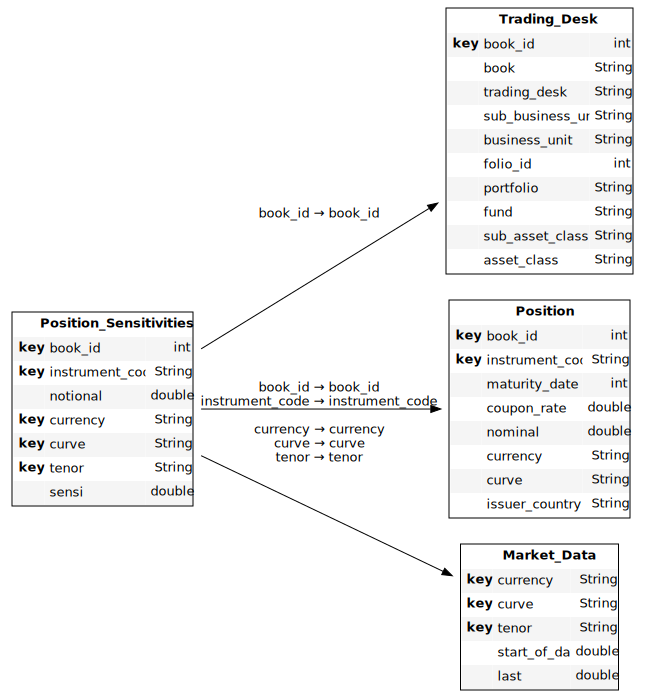

In [15]:
cube.schema

### Explore the Data Set as a Cube

We have the option to visualize the cube in chart, feature-value, pivot-table or tabular.  
Let's look at the sensitivity across currency for each asset class.

In [16]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Adding business logic calculation  
  
Let's assign a variable to the attributes of the cube, so that we can:  
* create measures
* create hierarchies 

In [17]:
m = cube.measures
h = cube.hierarchies
lvl = cube.levels

Let's inspect what hierarchies have been automatically generated during cube creation

In [18]:
h

{('Trading_Desk', 'portfolio'): <atoti.hierarchy.Hierarchy object at 0x000002AE538142E0>, ('Position', 'issuer_country'): <atoti.hierarchy.Hierarchy object at 0x000002AE5380CEE0>, ('Position_Sensitivities', 'tenor'): <atoti.hierarchy.Hierarchy object at 0x000002AE5380CFA0>, ('Trading_Desk', 'sub_business_unit'): <atoti.hierarchy.Hierarchy object at 0x000002AE5380CD00>, ('Position_Sensitivities', 'book_id'): <atoti.hierarchy.Hierarchy object at 0x000002AE5380CC10>, ('Position_Sensitivities', 'curve'): <atoti.hierarchy.Hierarchy object at 0x000002AE5380CA60>, ('Position_Sensitivities', 'instrument_code'): <atoti.hierarchy.Hierarchy object at 0x000002AE5380CAF0>, ('Trading_Desk', 'fund'): <atoti.hierarchy.Hierarchy object at 0x000002AE5380C7F0>, ('Trading_Desk', 'asset_class'): <atoti.hierarchy.Hierarchy object at 0x000002AE5380C700>, ('Trading_Desk', 'business_unit'): <atoti.hierarchy.Hierarchy object at 0x000002AE5380C550>, ('Position', 'currency'): <atoti.hierarchy.Hierarchy object at 0x000002AE5380C5E0>, ('Position', 'curve'): <atoti.hierarchy.Hierarchy object at 0x000002AE5380C2E0>, ('Trading_Desk', 'book'): <atoti.hierarchy.Hierarchy object at 0x000002AE53746580>, ('Trading_Desk', 'trading_desk'): <atoti.hierarchy.Hierarchy object at 0x000002AE5380C1F0>, ('Position_Sensitivities', 'currency'): <atoti.hierarchy.Hierarchy object at 0x000002AE53755BE0>, ('Trading_Desk', 'sub_asset_class'): <atoti.hierarchy.Hierarchy object at 0x000002AE53805EE0>}

Let's inspect what measures have been automatically generated during cube creation

In [19]:
m

{'contributors.COUNT': <atoti.measure.Measure object at 0x000002AE538141F0>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x000002AE53814BB0>, 'notional.SUM': <atoti.measure.Measure object at 0x000002AE53769A00>, 'notional.MEAN': <atoti.measure.Measure object at 0x000002AE53769340>, 'sensi.SUM': <atoti.measure.Measure object at 0x000002AE537695E0>, 'sensi.MEAN': <atoti.measure.Measure object at 0x000002AE537696A0>}

### Creating Measures

From the *Market Data* store, we have the *start of day* and *end of day* value which we used to calculate the change in yields.  

In [20]:
m["last.VALUE"] = tt.agg.single_value(market_data_table["last"])
m["start_of_day.VALUE"] = tt.agg.single_value(market_data_table["start_of_day"])

#### Parameter simulation setup

We are going to create a parameter simulation measure `last parameter` that will allow us to create fluctuations to the `last.VALUE`.
This measure will be added to the `last.VALUE` based on scenarios, at specific *tenor* and *currency* levels.

The default value of `last parameter` will be 0.0, hence zero fluctuation from the original value when not defined in the scenario.  
We will label the curve derived from the original data set as *Last Curve*

In [21]:
curve_simulation = cube.create_parameter_simulation(
    "Curve Simulation",
    measures={"last parameter": 0.0},
    levels=[lvl["tenor"], lvl[("Position_Sensitivities", "currency", "currency")]],
    base_scenario_name="Last Curve",
)

As the fluctuations will be by [basis points](https://www.investopedia.com/ask/answers/what-basis-point-bps/), let's format the `last parameter` to show 3 decimal points.

In [22]:
m["last parameter"].formatter = "DOUBLE[#.000]"

Taking in consideration the potential fluctuations in the `last.VALUE` induced by the simulation, let's compute the `effective last` as follows:

In [23]:
m["effective last"] = tt.agg.sum(
    m["last.VALUE"] + m["last parameter"],
    scope=tt.OriginScope(
        lvl["tenor"], lvl[("Position_Sensitivities", "currency", "currency")]
    ),
)

Realized that we have aggregated the values over additional scope of `tenor` and `currency`? That's because we are running simulation along these levels.  
We will come back to the simulations later on in the notebook. For now, let's look at how we can compute our Theoretical Pnl.

#### Theoretical Pnl

We derive our Delta by applying `sensi.SUM` to the [notional](https://www.investopedia.com/terms/n/notionalvalue.asp). We, then apply Delta to our change in yield to get the impact of prices:
  
$Theoretical Pnl = (Delta) \times (Yield Change)$  

We will aggregate the *Theoretical PnL* over the levels listed in the scope below as we will be exploring the measure over these levels.  
Notice that we are using the `effective last` measure here to compute the delta.

In [24]:
m["Theoretical PnL"] = tt.agg.sum(
    m["sensi.SUM"]
    * (m["effective last"] - m["start_of_day.VALUE"])
    * m["notional.SUM"],
    scope=tt.OriginScope(
        lvl[("Position_Sensitivities", "currency", "currency")],
        lvl[("Position_Sensitivities", "curve", "curve")],
        lvl["tenor"],
        lvl["book_id"],
        lvl["instrument_code"],
    ),
)

### Adding new multi-level hierarchy for portfolio structure  

Based on the data that are of interest to the [Buy-Side](https://www.investopedia.com/terms/b/buyside.asp) and [Sell-Side](https://www.investopedia.com/terms/s/sellside.asp), we are going to see how we can structure hierarchies to facilitate the navigation of data in a cube.  

#### Asset Mangement : Buy-Side  

*Buy-Side* purchases stocks, securities and other financial products, according to the needs and strategy of a portfolio.  
It would make data navigation more intuitive to create an *Investment Portfolio Hierarchy* that has Asset Class, Sub Asset Class, Fund and Portfolio as levels.  
We would be able to have a global view over the Asset Class level.  
If we needed more granular information, we could easily drill-down to the Sub Asset class, Fund and all the way down to the portfolio holding the Asset.

In [25]:
h["Investment Portfolio Hierarchy"] = {
    "Asset Class": cube.levels["asset_class"],
    "Sub Asset Class": cube.levels["sub_asset_class"],
    "Fund": cube.levels["fund"],
    "Portfolio": cube.levels["portfolio"],
}

#### Investment Banks : Sell-Side  

*Sell-Side* help companies to raise debt and equity capital and then sell those securities to the *Buy-Side*.  \
*Sell-Side* would then be interested in having a global view over the *Business Unit* such as Rates & Credit, Forex, Equity etc.    
They could then drill-down to the *Sub Business Unit* to see its performance, the *Trading Desk* and all the way to the *Book* level.

In [26]:
h["Trading Book Hierarchy"] = {
    "Business Unit": lvl["business_unit"],
    "Sub Business Unit": lvl["sub_business_unit"],
    "Trading Desk": lvl["trading_desk"],
    "Book": lvl["book"],
}

### Explore the Theoretical PnL by Investment Portfolio Hierarchy

We shall explore the Theoretical PnL from the Buy-Side perspective.  
  
Let's visualize the data in a chart to see the spread of the *Theoretical PnL* across the funds for each *Asset Class*.

In [27]:
session.visualize("Theoretical PnL spread across funds")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In the next 2 visualizations, we shall see the impact of having the *Investment Portfolio Hierarchy*.

In the first tree map, we perform a split at the *portfolio* level from *Investment Portfolio Hierarchy*. This means that we are drilling down from the Asset class to Sub Asset Class, Fund and then to the Portfolio level. E.g. we will see the portfolio HE01 under the Asset Class *Rates & Credit* and *Forex*.

In [28]:
session.visualize("Investment Portfolio concentration")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In this second tree map, we perform a split at the *portfolio* hierarchy.  
Hence we will only see the collective *Theoretical PnL* of the portfolio. E.g. we will only see 1 HE01 in this map.

In [29]:
session.visualize("Portfolio concentration")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In the below pivot-table, we can easily drill-down the levels in the *Investment Portfolio Hierarchy* to see measures at granular levels.  
Naturally, this could also be achieved by clicking on `>+` and manually adding a hierarchy to drill down to. It's just a little more tedious.

In [30]:
session.visualize("Investment Portfolio Hierarchy Pivot Table")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Yield Curve

The *Yield Curve* gives insights to the future interest rate changes and economic activity. 
  
A normal yield curve which shows an upward curve, shows longer-term bonds having higher yields than short-term ones. Short-term interest rates are the lowest because there is less embedded inflation risk. This shows economic expansion.

An inverted curve which has a downward slope, is a sign of an upcoming recession. The shorter-term bonds yields higher than the longer-term ones.  

A flat or humped yield curve shows that the yields for shorter- and longer-term bonds are very close to each other. Investors are expecting interest rates to remain about the same, probably an economic transition.
  
We will use the start of day and last rates against the tenor to plot our yield curve. We should be able to see a normal upward yield curve in the chart below.

In [31]:
session.visualize("Yield Curve")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We see that *Rates & Credit* has the highest *Theoretical PnL* among the Asset class.

In [32]:
session.visualize("Theoretical PnL")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

By applying sensitivity against the Asset Class and Currency, we can see that the 3 peaks are in the order of *Rates & Credit, EUR*, *Forex, EUR* and lastly *Equity, EUR*. 

In [33]:
session.visualize("Risk Map")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### What-ifs using Parameter simulations
We will run simulations to see the impact of shifts in curves: 
- Parallel Shift
- Curve Inversion
- Curve Inversion Stress


#### Shift Simulation  
  
A parallel shift in the yield curve happens when the interest rates on all fixed-income maturities increase or decrease by the same number of basis point.  
The curve does not change but it shifts to the left or to the right. This is most common when the yield curve is upward sloping.  
  
This simulation is important for investors who might liquidate their positions before maturity, as the shift can cause bond prices to fluctuate substantially.  
Investors could mitigate this risk by reducing the bond duration, alleviate the volatility.


Earlier, we have created the parameter simulation `curve_simulation`.  
We will use it to simulate parallel shift in yield curve by applying a negative 10 [bps](https://www.investopedia.com/ask/answers/what-basis-point-bps/) shift on the last rate for Euro currency on all Tenor.

In [34]:
curve_simulation += ("Curve Parallel Shift", None, "EUR", -0.001)

The above snippet creates a scenario `Curve Parallel Shift`, followed by the levels that is affected by this simulation and the value of `last parameter`.  
`None` is a wildcard value, indicating that it will affect all the Tenors

##### Explore Curve Parallel Shift scenario impact on Theoretical PnL  
  
We see that while the curve retains its shape, all the data points moved to the right of the graph.

In [35]:
session.visualize("Yield Curve Curve Parallel Shift")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let's now go into the investment portfolio to see the impact of this shift on the *Theoretical PnL*.  \
We see the *Theoretical PnL* went negative on a 10bps shift, with *Rates & Credit* suffering the most loss.  

In [36]:
session.visualize("Theoretical PnL Parallel Shift - Investment Portfolio")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Curve Inversion Simulation

An inverted yield curve is a predictor of economic recession as it implies that interest rates are going to fall. In fact, recessions usually cause interest rates to fall.  
  
Short-term bills are expected to plummet if recession is coming, as Federal Reserve will lower the fed funds rate when economy slows down. Therefore investors may avoid Treasurys with maturities of less than two years to have a safe investment. This sets back the demand for those bills and sends their yields up. Higher demands in the longer-term instruments lower the yields, hence an inverted curve occurs.

Let's run another simulation on the currency EUR and see the impact on the *Theoretical PnL*.
We will set `last parameter` to a negative 20bps for the currency EUR for tenors 5Y and above and observe the change in the curve shape.

In [37]:
curve_simulation += ("Curve Inversion", "5Y", "EUR", -0.002)
curve_simulation += ("Curve Inversion", "6Y", "EUR", -0.002)
curve_simulation += ("Curve Inversion", "7Y", "EUR", -0.002)
curve_simulation += ("Curve Inversion", "8Y", "EUR", -0.002)
curve_simulation += ("Curve Inversion", "9Y", "EUR", -0.002)

##### Explore Curve Inversion scenario impact on Theoretical PnL  
  
We see a slight inversion in the curve from the tenor 4Y to 5Y before it becomes a shift to the right, as in the case of a parallel shift.  
In this case, we predict that the yields will dip for instruments with more than 5Y maturity.

In [38]:
session.visualize("Yield Curve Inversion")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

As expected, we can see drastic drop in the *Theoretical PnL* across all the asset classes, the greatest loss incurred in the asset class *Rates & Credit*.

In [39]:
session.visualize("Theoretical PnL Curve Inversion")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [40]:
session.visualize("Theoretical PnL against Tenor")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Curve Inversion Stress Simulation  
  
We will create a new scenario where we stress the curve further by assuming further drops in rates for the longer-term instruments.  

In [41]:
curve_simulation += ("Curve Inversion Stress", "5Y", "EUR", -0.002)
curve_simulation += ("Curve Inversion Stress", "6Y", "EUR", -0.002)
curve_simulation += ("Curve Inversion Stress", "7Y", "EUR", -0.004)
curve_simulation += ("Curve Inversion Stress", "8Y", "EUR", -0.004)
curve_simulation += ("Curve Inversion Stress", "9Y", "EUR", -0.004)

##### Explore Curve Inversion Stress scenario impact on Theoretical PnL  
  
We see the curve is starting to slope more downward.

In [42]:
session.visualize("Yield Curve Inversion Stress")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We see the downward slope dipped further in the stress scenario.

In [43]:
session.visualize("Theoretical PnL Curve Inversion Stress")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [44]:
session.visualize("Scenarios Comparison")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Build Your Standalone App using atoti UI:

* Publish Yield Curve and PnL Views
* Add Page Quick filters
* Compare scenarios
* Save Dashboards  
  
You can access atoti UI with the link below:

In [45]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

We can publish the visualizations above as widgets to atoti UI. Click on *Open App* when you have published all the widgets of interest.  

<img src="https://data.atoti.io/notebooks/pnl-explained/publish_widget.gif" alt="publish widget" style="zoom:40%;" />

We can quickly put together a PnL Explained dashboard.  

<img src="https://data.atoti.io/notebooks/pnl-explained/dashboarding.gif" alt="dashboard design" style="zoom:40%;" />  
  
Access the above dashboard with the link provided below:

In [46]:
session.link(path="/#/dashboard/223")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=pnl-explained" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>